# Panda robot identification and LQR control

In [12]:
import numpy as np
from numpy import random as rnd
from numpy.linalg import pinv
from numpy import linalg as lg
from scipy import linalg as slg
from importlib import reload
import seaborn as snb
import matplotlib.pyplot as plt
import Utils.Functions 
from Utils.Functions import *
import pbdlib as pbd
from scipy.linalg import hankel
from hyperopt import tpe, hp, fmin, STATUS_OK, Trials
import joblib
import pybullet
from pbdlib import LQR
from pbdlib.utils import get_canonical
import pandapybullet as ppb
import skopt as sk
%load_ext autoreload
%autoreload 2
plt.style.use("default")
plt.rcParams['font.size'] = 13
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['lines.linewidth'] = 2.5
np.set_printoptions(precision=5, suppress=False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Gather training data 
### Define random sine reference

Run a LQR using desired joint position and velocity to retrieve jooitn acceleration

In [4]:
dt = 1e-3
world_sim = ppb.WorldSim()
world_sim.setup_scene()
world_sim.load_table()
robot = world_sim.load_panda()

C:\Users\cedri\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [90]:
# N=5000
# T = N*dt
# A,B = get_canonical(7,nb_deriv=2,dt=dt)
# lqr = LQR(A, B, dt=dt, horizon=N)
# lqr.gmm_u = -6.
# lqr.Q = np.diag([1e3]*14)

# n_training = 5
# n_testing = 3
# n_tot = n_training + n_testing
# desired_q = np.empty(shape=[n_tot,7,N])
# desired_dq = np.empty(shape=[n_tot,7,N])
# desired_ddq = np.empty(shape=[n_tot,7,N-1])

# t = np.linspace(0.,N*dt,N)
# a = rnd.uniform(low=.5, high=1, size=n_tot)
# b = (2*np.pi/T)*rnd.uniform(low=1., high=1.5, size=n_tot)

# for i, (a, b) in enumerate(zip(a,b)):
#     desired_q[i,:,:] = (robot.default_q[None] + np.stack([-a*np.cos(b*t)+a]*4+[-a*np.cos(b*t)+a]*3).T).T
#     desired_dq[i,:,:] = (np.stack([a*b*np.sin(b*t)]*4+[a*b*np.sin(b*t)]*3).T).T # Derivative

#     z = np.concatenate([desired_q[i,:,:].T, desired_dq[i,:,:].T],1)
#     lqr.z = z
#     lqr.ricatti()

#     xs, us = lqr.get_seq(z[0])
#     desired_ddq[i,:,:] = us.T

In [5]:
robot.default_q = np.array([deg2rad(180),deg2rad(40),deg2rad(0),deg2rad(-150),deg2rad(0),deg2rad(90),deg2rad(0)])
robot.reset_q()
robot.x

array([-0.51321, -0.4585 ,  0.96176])

In [42]:
N=10000
T = N*dt
n_training = 5
n_testing = 2
n_tot = n_training + n_testing
joint_limits = robot.joint_limits.copy()
joint_limits[1,:] = [-deg2rad(35),deg2rad(35)]
# joint_limits[3,0] = -deg2rad(60)

# Trajectories specifications
specs = {'phi': {'low': -np.pi, 'high': np.pi}, 
         'A': {'low': -np.pi, 'high': np.pi},
         'f': {'low': 1/20, 'high': .3},
         'nb_parts': 100, 'margin': .1, 'safety': .9}

pandaRobot = Robot(7, 7, dt, N, robot)
pandaRobot.drawTrajectories(nb_traj=n_tot, q_limits=joint_limits, specs=specs)

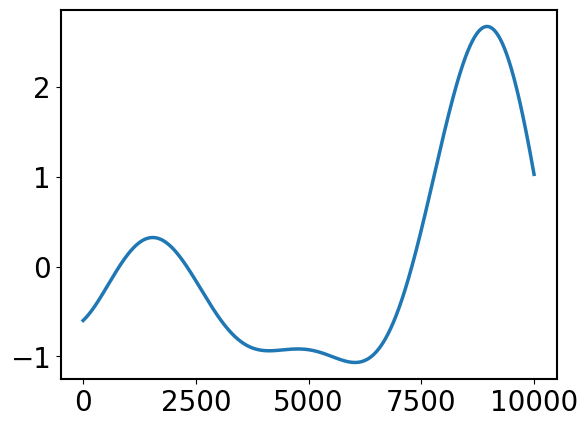

[-2.9671  2.9671]
-1.067446316500055 2.67039
[[-2.9671  2.9671]
 [-1.8326  1.8326]
 [-2.9671  2.9671]
 [-3.1416  0.    ]
 [-2.9671  2.9671]
 [-0.0873  3.8223]
 [-2.9671  2.9671]]


In [31]:
joint = 4
traj = 3
plt.plot(pandaRobot.ref[traj,joint,:])
# plt.plot(pandaRobot.desired_ddq[4,traj,:])
plt.show()
print(robot.joint_limits[joint,:])
print(min(pandaRobot.ref[traj,joint,:]), max(pandaRobot.ref[traj,joint,:]))
print(robot.joint_limits)

## Gather training data using CTC + PD

### Tune PD controller

In [32]:
Kp = np.diag([200]*7)
Ki = np.eye(7)*5.
Kd = np.eye(7)*5.

robot.reset_q(max_iter=100)
robot.joints_free=True

joints are free now


C:\Users\cedri\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [11]:
robot.joint_torque_limits

array([[-87.,  87.],
       [-87.,  87.],
       [-87.,  87.],
       [-87.,  87.],
       [-12.,  12.],
       [-12.,  12.],
       [-12.,  12.]])

### Simulate using CTC + PD

In [43]:
log_control = np.empty(shape=[n_tot,7,N-1])
log_q = np.empty(shape=[n_tot,7,N])
log_dq = np.empty(shape=[n_tot,7,N])
log_ddq = np.empty(shape=[n_tot,7,N])

for n in range(n_tot):
    log_error = []
    sum_error = np.zeros(7)
    log_q[n,:,0] = robot.q
    log_dq[n,:,0] = robot.dq
    log_ddq[n,:,0] = robot.ddq
    
    robot.default_q = pandaRobot.ref[n,:7,0]
    robot.reset_q(max_iter=100)
    robot.joints_free=True
    for i in range(0, N-1):
        error_q = pandaRobot.ref[n,:7,i] - robot.q
        error_dq = pandaRobot.ref[n,7:,i] - robot.dq

    #   Computed Torque Control
        control_input = robot.configuration_ctc(Kp @ error_q + Ki @ sum_error + Kd @ error_dq + pandaRobot.desired_ddq[n,:,i])
        
        for j in range(7):
            if control_input[j] < robot.joint_torque_limits[j,0]:
                control_input[j] = robot.joint_torque_limits[j,0].copy()
            if control_input[j] > robot.joint_torque_limits[j,1]:
                control_input[j] = robot.joint_torque_limits[j,1].copy()

        robot.set_torque(control_input[:7])

        log_error.append(np.copy(error_q))
        log_q[n,:,i] = robot.q.copy()
        log_dq[n,:,i] = robot.dq.copy()
        log_ddq[n,:,i] = robot.ddq.copy()
        log_control[n,:,i] = np.copy(control_input)
    #     time.sleep(dt)
        sum_error += error_q*dt

C:\Users\cedri\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


joints are free now
joints are free now
joints are free now
joints are free now
joints are free now
joints are free now
joints are free now


[-87.      -87.      -87.      ...  -3.92058  -3.92921  -3.93299]


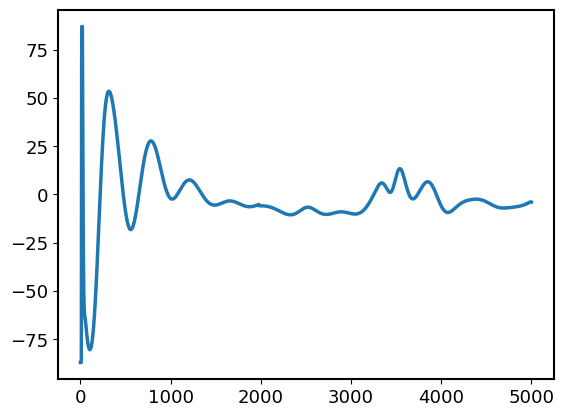

In [17]:
plt.plot(log_control[0,0,:])
plt.show
print(log_control[0,0,:])

### Store data in state-space form

In [44]:
pandaRobot.toStateSpace(log_q, log_dq, log_control)

## Model training 

### Bayesian optimisation framework

In [1]:
# Hyperparameters space
traj_ratio = .02
n_low, n_high = 15, 100
d_low, d_high = 1, np.int((1-traj_ratio)/n_high*pandaRobot.N)
print(pandaRobot.N- d_high*n_high)
print(d_high)
#######################################################
space = {
    "dimension": hp.quniform("dimension", 14, 150, 1),
    "nb_trajectories": hp.quniform("nb_trajectories", n_low, n_high, 1),
    "nb_delays": hp.quniform("nb_delays", d_low, d_high, 1),
}
#######################################################
loss_traj = np.empty(shape=[n_training])
loss_U = np.empty(shape=[n_training])
loss_LQR = np.empty(shape=[n_training])

def hyperparameters_tuning(params):
    
    # Model parameters
    n = np.int(params["nb_trajectories"])
    d = np.int(params["nb_delays"])
    s = np.int(params["dimension"])
    
    for fold in range(n_training):
        model = HAVOK(pandaRobot.dX[fold,:,:], pandaRobot.dU[fold,:,:], learnOnDiff=True)
#         model = HAVOK(pandaRobot.X[fold,:,:], pandaRobot.U[fold,:,:])
        model.HANKEL(n, d)
        model.SVD(s)
        model.LS(s,rcond=0)
        model.Simulate(pandaRobot.ref[fold,:,0],U_testing = pandaRobot.U[fold,:]) # Learn on differences
        
        # LQR loss ##############################
        model.ConstructLQR(x_std=1e6*np.ones(pandaRobot.nb_S), u_std=2., dt=dt, ref=pandaRobot.ref[fold,:,:]) # To learn on differences
        model.LQR_simulate(X0=pandaRobot.ref[fold,:,0])
        
        loss_traj[fold] = model.RMSE(X_pred=model.X_traj, X_true=pandaRobot.X[fold,:,:]) 
        loss_LQR[fold] = model.RMSE(X_pred=model.LQR_X[:7,:], 
                                    X_true=pandaRobot.ref[fold,:7,:])
#         loss_U[fold] = model.RMSE(X_pred=model.LQR_U[0,:,:].T, 
#                                   X_true=pandaRobot.U[fold,:,:])

#     loss = (loss_LQR.sum() + 3*loss_U.sum())/n_training
#     loss = (loss_LQR.sum() + loss_U.sum())/n_training
    loss = (loss_LQR.sum())/n_training
    
    print('Hyperparameters {}'.format(params), 'Loss {}'.format(loss))
    print('loss : '+str(loss)+' traj : '+str(loss_traj.sum()/n_training)+' LQR : '+str(loss_LQR.sum()/n_training)+' U :'+str(loss_U.sum()/n_training))
    
    return {"loss":loss, "status":STATUS_OK}
#######################################################
trials = joblib.load('hyperopt_trials.pkl')
# trials = Trials()

best = fmin(
    fn = hyperparameters_tuning,
    space = space, 
    algo = tpe.suggest, 
    max_evals = 100, 
    trials = trials
)

joblib.dump(trials, 'hyperopt_trials.pkl')

print('Best hyperparameters {}'.format(best))

NameError: name 'np' is not defined

### Using *Scikit-optimize*

In [48]:
traj_ratio = .02
n_low, n_high = 15, 100
d_low, d_high = 1, np.int((1-traj_ratio)/n_high*pandaRobot.N)

SPACE = [
    sk.space.Integer(14, 200, name='dimension'), 
    sk.space.Integer(n_low, n_high, name='nb_traj'),
    sk.space.Integer(d_low, d_high, name='nb_delays')
]

print('delay max : ',np.int((1-traj_ratio)/n_high*pandaRobot.N))
print('points min : ',pandaRobot.N- d_high*n_high)

# n_training = 5 # Number of trainings per epoch
loss_traj = np.empty(shape=[n_training])
loss_U = np.empty(shape=[n_training])
loss_LQR = np.empty(shape=[n_training])

# @use_named_args(SPACE)
def loss(SPACE):
    # Model parameters
    n = SPACE[1]
    d = SPACE[2]
    s = SPACE[0]
    
    for fold in range(n_training):
        model = HAVOK(pandaRobot.dX[fold,:,:], pandaRobot.dU[fold,:,:], learnOnDiff=True)
#         model = HAVOK(pandaRobot.X[fold,:,:], pandaRobot.U[fold,:,:])
        model.HANKEL(n, d)
        model.SVD(s)
        model.LS(s,rcond=0)
#         model.Simulate(pandaRobot.ref[fold,:,0],U_testing = pandaRobot.U[fold,:]) # Learn on differences
        
        # LQR loss ##############################
        model.ConstructLQR(x_std=1e6*np.ones(pandaRobot.nb_S), u_std=2., dt=dt, ref=pandaRobot.ref[fold,:,:]) # To learn on differences
        model.LQR_simulate(X0=pandaRobot.ref[fold,:,0])
        
#         loss_traj[fold] = model.RMSE(X_pred=model.X_traj, X_true=pandaRobot.X[fold,:,:]) 
        loss_LQR[fold] = model.RMSE(X_pred=model.LQR_X[:7,:], 
                                    X_true=pandaRobot.ref[fold,:7,:])
    loss = (loss_LQR.sum())/n_training
    
    return loss

nb_calls = 50

def monitor(res):
    print('run_score : '+str(res.func_vals[-1]))
    print('(dimension,nb_traj,nb_delay) = '+str(res.x_iters[-1]))

# old_results = skopt.load('results/HYP_TUN1.pkl')

results = sk.gp_minimize(loss, SPACE, n_calls=nb_calls, callback=[monitor])

skopt.dump(results, 'results/HYP_TUN1.pkl')

delay max :  98
points min :  200
run_score : 85.61437670999189
(dimension,nb_traj,nb_delay) = [27, 96, 15]
run_score : 98.62755227279035
(dimension,nb_traj,nb_delay) = [178, 29, 81]
run_score : 83.541610361482
(dimension,nb_traj,nb_delay) = [134, 48, 3]
run_score : 101.75761712114031
(dimension,nb_traj,nb_delay) = [198, 79, 31]
run_score : 96.70871824386737
(dimension,nb_traj,nb_delay) = [31, 44, 64]


KeyboardInterrupt: 

## LQR control of the Panda robot
### Construct LQR planner

Forward prediction RMSE : 141.7741297421725
LQR RMSE : 96.07142061458242


(Text(0.5, 0, 'Time [s]'), Text(0.5, 0, 'Time [s]'))

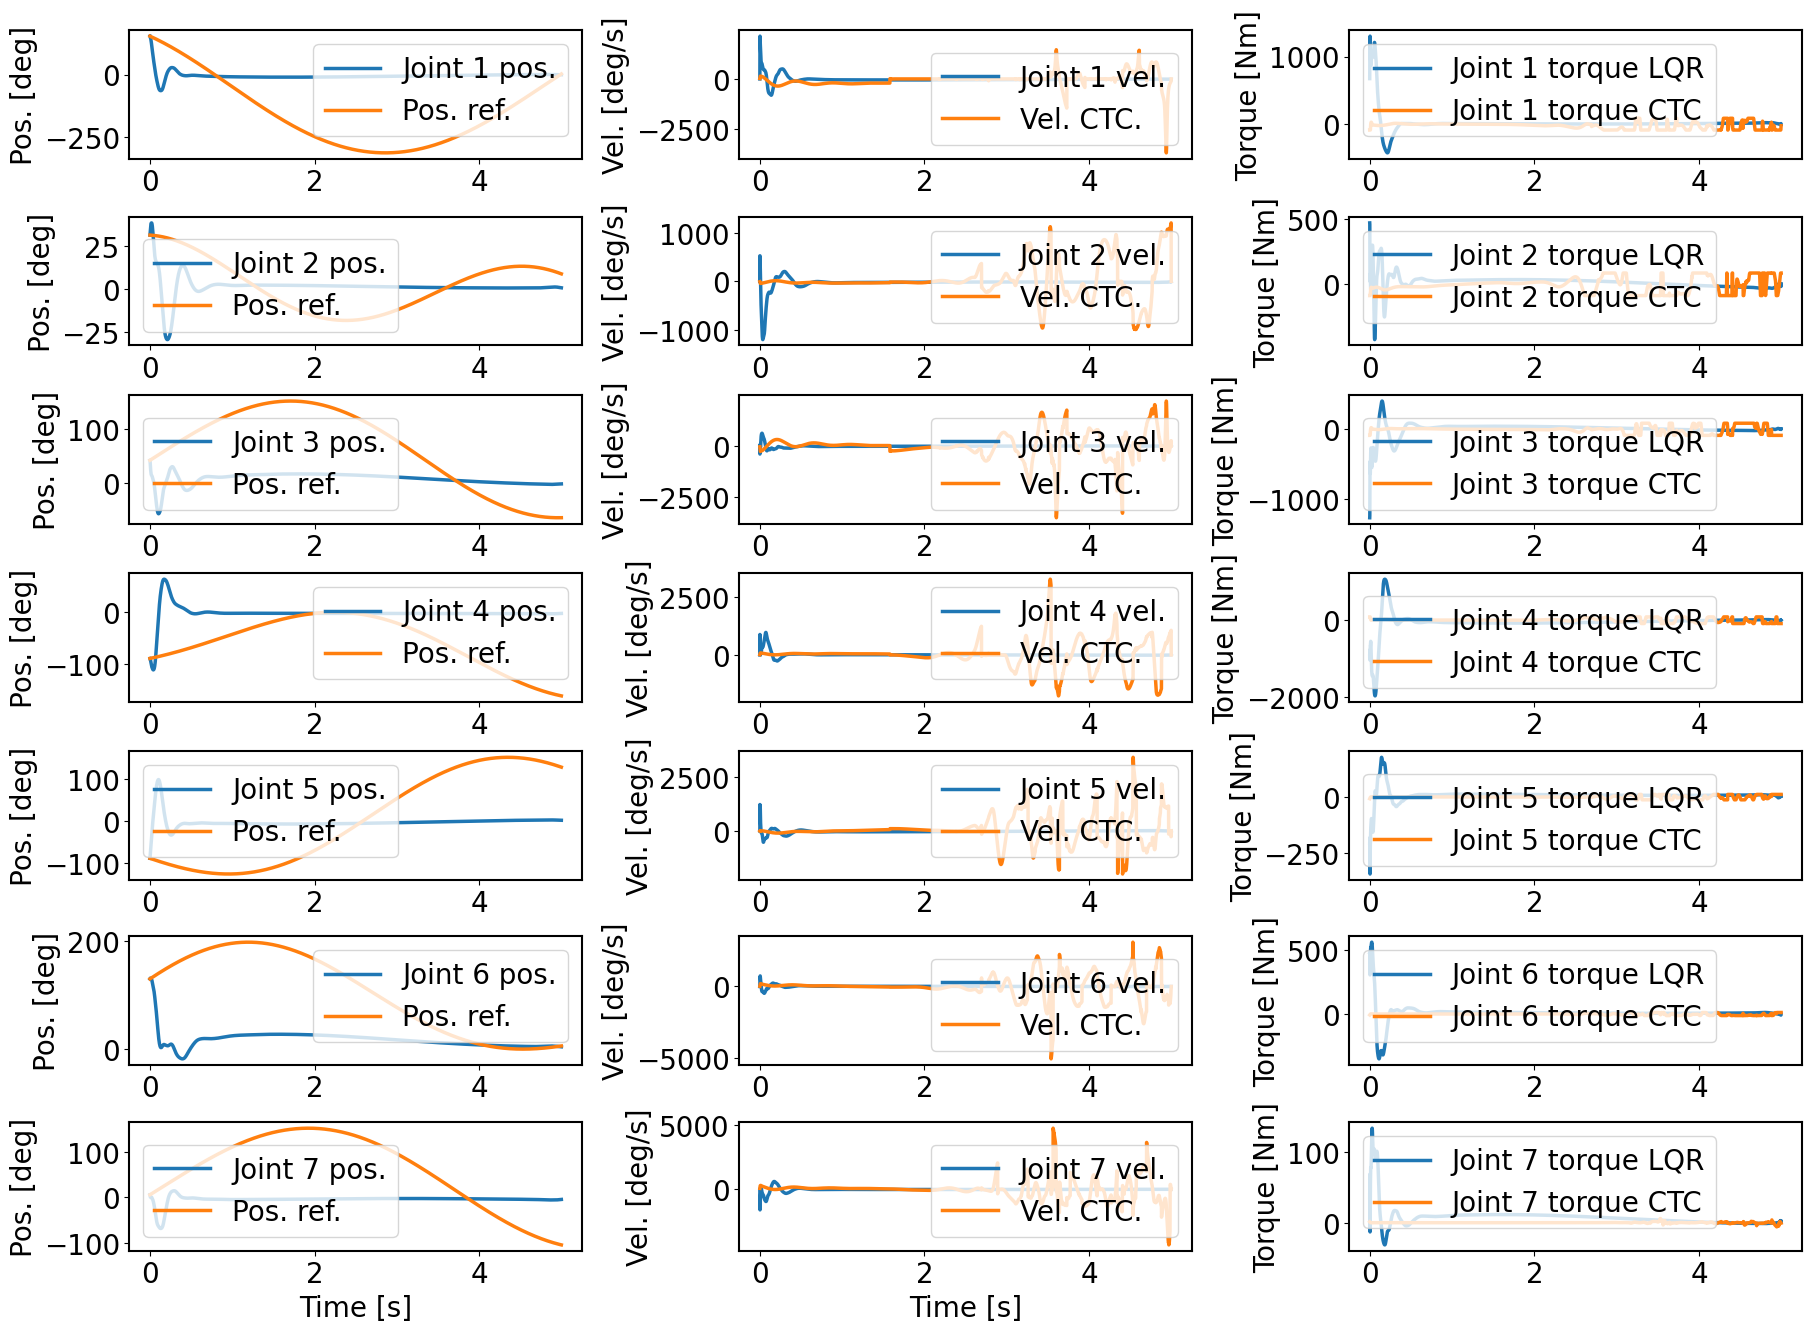

In [27]:
# Train linear model
traj = 4

n = 15
r = 145
d = 4

model = HAVOK(pandaRobot.dX[traj,:,:], pandaRobot.dU[traj,:,:], learnOnDiff=True)
model.HANKEL(n, d)
model.SVD(r)
model.LS(r,rcond=0)
model.Simulate(pandaRobot.X[traj,:,0],U_testing = pandaRobot.U[traj,:])

loss_traj_train = model.RMSE(X_pred=model.X_traj, X_true=pandaRobot.X[traj,:,:]) 
print('Forward prediction RMSE : '+str(loss_traj_train))

# Train LQR controller
model.ConstructLQR(x_std=1e6*np.ones(pandaRobot.nb_S), u_std=2., dt=dt, ref=pandaRobot.ref[traj,:,:]) # To learn on differences
model.LQR_simulate(X0=pandaRobot.ref[traj,:,0])

loss_LQR_subspace = model.RMSE(X_pred=model.LQR_X[:7,:], 
                                    X_true=pandaRobot.ref[traj,:7,:])
print('LQR RMSE : '+str(loss_LQR_subspace))

# plt.rcParams['font.size'] = 20
# fig, ax = plt.subplots(1, 2, constrained_layout = True, figsize=(18,8))

# figA = snb.heatmap(model.A,cmap='Reds',ax=ax[0])
# figB = snb.heatmap(model.B,cmap='Reds',ax=ax[1])

plt.rcParams['font.size'] = 20
fig, ax = plt.subplots(7, 3, constrained_layout = True, figsize=(18,13))

for i in range(7):
    
    ax[i,0].plot(pandaRobot.T, rad2deg(model.LQR_X[i,:]), label='Joint '+str(i+1)+' pos.')
    ax[i,0].plot(pandaRobot.T, rad2deg(pandaRobot.ref[traj,i,:]), label='Pos. ref.')
    ax[i,1].plot(pandaRobot.T, rad2deg(model.LQR_X[7+i,:]), label='Joint '+str(i+1)+' vel.')
    ax[i,1].plot(pandaRobot.T, rad2deg(pandaRobot.X[traj,7+i,:]), label='Vel. CTC.')
    ax[i,2].plot(pandaRobot.T[:len(pandaRobot.T)-1], model.LQR_U[0,:,i], label='Joint '+str(i+1)+' torque LQR')
    ax[i,2].plot(pandaRobot.T[:len(pandaRobot.T)-1], pandaRobot.U[traj,i,:], label='Joint '+str(i+1)+' torque CTC')
    ax[i,0].set_ylabel('Pos. [deg]'), ax[i,1].set_ylabel('Vel. [deg/s]'), ax[i,2].set_ylabel('Torque [Nm]')
    ax[i,0].legend(), ax[i,1].legend(), ax[i,2].legend()
    
ax[6,0].set_xlabel('Time [s]'), ax[6,1].set_xlabel('Time [s]')

### Plot CTC trajectory

(Text(0.5, 0, 'Time [s]'), Text(0.5, 0, 'Time [s]'))

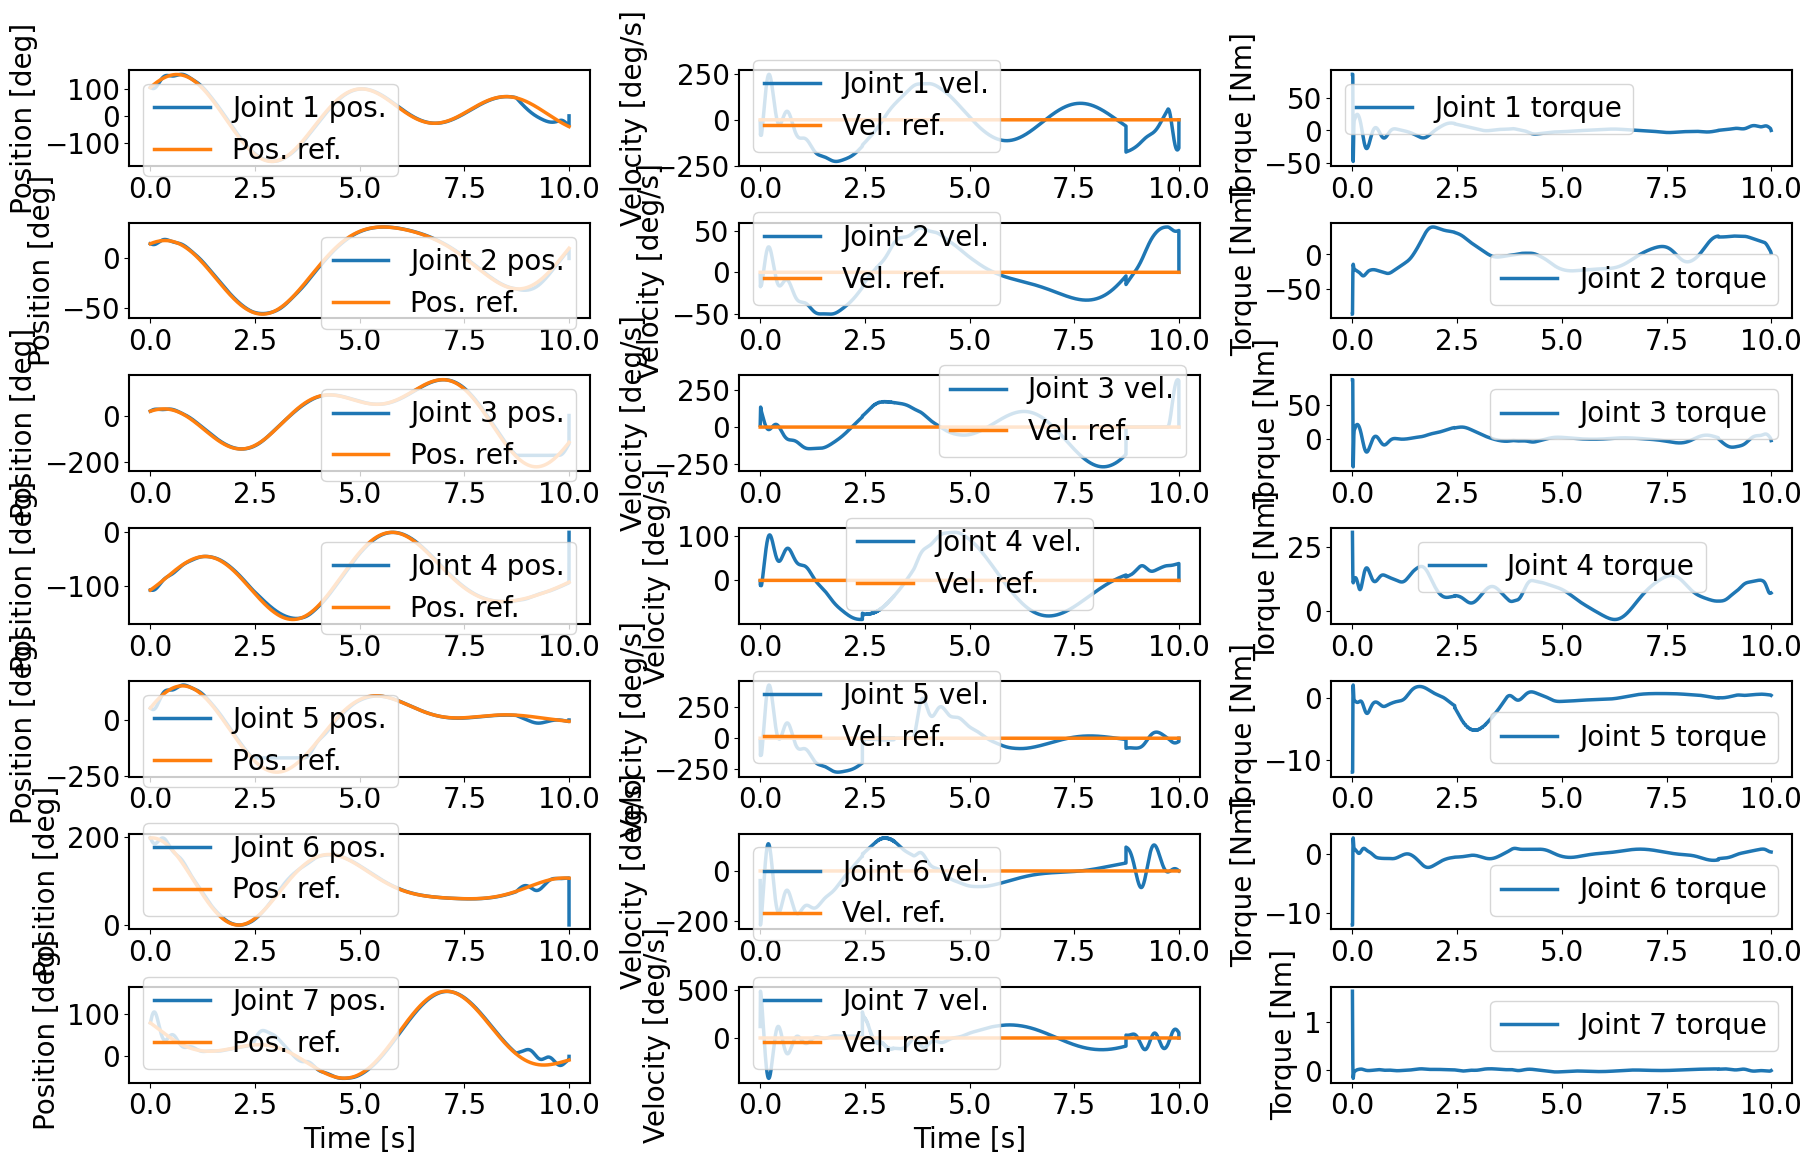

In [45]:
traj = 4
plt.rcParams['font.size'] = 20
fig, ax = plt.subplots(7, 3, constrained_layout = True, figsize=(18,11))

for i in range(7):
    
    ax[i,0].plot(pandaRobot.T, rad2deg(pandaRobot.X[traj,i,:]), label='Joint '+str(i+1)+' pos.')
    ax[i,0].plot(pandaRobot.T, rad2deg(pandaRobot.ref[traj,i,:]), label='Pos. ref.')
    ax[i,1].plot(pandaRobot.T, rad2deg(pandaRobot.X[traj,i+7,:]), label='Joint '+str(i+1)+' vel.')
    ax[i,1].plot(pandaRobot.T, rad2deg(pandaRobot.ref[traj,i+7,:]), label='Vel. ref.')
    ax[i,2].plot(pandaRobot.T[:len(pandaRobot.T)-1], pandaRobot.U[traj,i,:], label='Joint '+str(i+1)+' torque')
    ax[i,0].set_ylabel('Position [deg]'), ax[i,1].set_ylabel('Velocity [deg/s]'), ax[i,2].set_ylabel('Torque [Nm]')
    ax[i,0].legend(), ax[i,1].legend(), ax[i,2].legend()
    
ax[6,0].set_xlabel('Time [s]'), ax[6,1].set_xlabel('Time [s]')

### Apply LQR planner onto real robot dynamics

C:\Users\cedri\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


joints are free now
LQR RMSE : 497.4645270185171


(Text(0.5, 0, 'Time [s]'), Text(0.5, 0, 'Time [s]'))

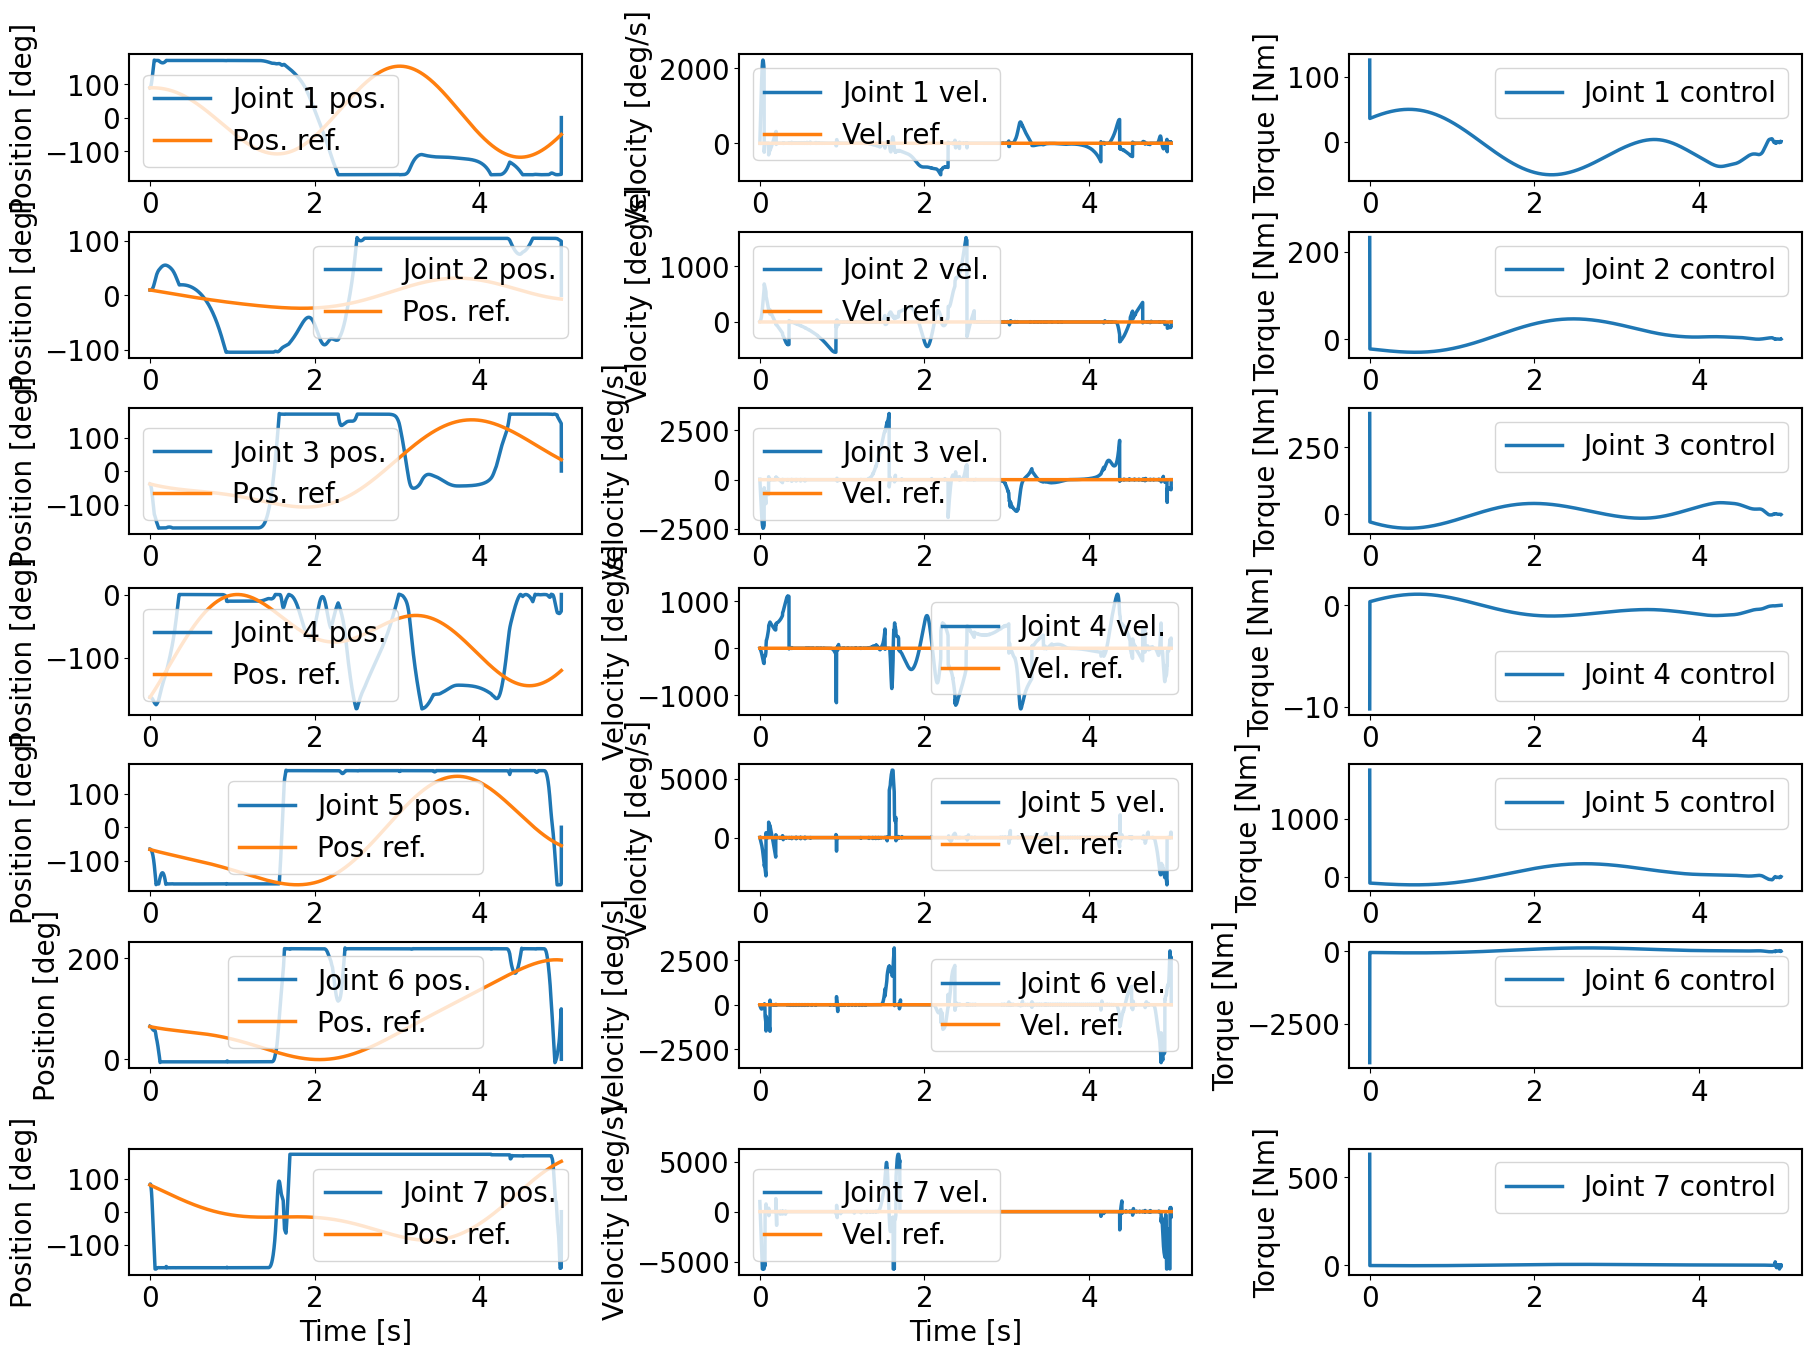

In [23]:
X0 = pandaRobot.ref[traj,:,0]
Xc, Yc = np.zeros(shape=[model.nb_S,model.N]), np.zeros(shape=[model.tau,model.N])
Uc = np.empty(shape=[model.nb_U,model.N-1])

# Initial condition
Xc[:,0] = X0
# N = np.eye(model.tau) - pinv(model.C) @ model.C
Y0 = pinv(model.C)@X0
# Y0 = Y0 + N@(model.Y[:,0] - Y0) # Nullspace projection into subspace 
Yc[:,0] = Y0

robot.default_q = Xc[:7,0]
robot.reset_q(max_iter=100)
robot.joints_free=True

sum_error = np.zeros(7)

# Simulate the closed-loop trajectory for the non-linear dynamics
for i in range(model.N-1):

#   LQR planner control input
    control_input = model.LQR.get_command(Yc[:,i],i)

    robot.set_torque(control_input[:7])

    log_error.append(np.copy(error_q))
    Xc[0:7,i] = robot.q
    Xc[7:,i] = robot.dq
#     log_ddq[n,:,i] = robot.ddq
    Uc[:,i] = np.copy(control_input)
#     time.sleep(dt) # Real-time rendering
    sum_error += error_q*dt
    
    Yc[:,i+1] = pinv(model.C)@Xc[:,i+1]
    
loss_LQR_true = model.RMSE(X_pred=Xc[, 
                                    X_true=pandaRobot.ref[traj,:,:])
print('LQR RMSE : '+str(loss_LQR_true))
    
plt.rcParams['font.size'] = 20
fig,ax = plt.subplots(7, 3, constrained_layout = True, figsize=(18,13))

for i in range(7):
    
    ax[i,0].plot(pandaRobot.T, rad2deg(Xc[i,:]), label='Joint '+str(i+1)+' pos.')
    ax[i,0].plot(pandaRobot.T, rad2deg(pandaRobot.ref[traj,i,:]), label='Pos. ref.')
    ax[i,1].plot(pandaRobot.T, rad2deg(Xc[i+7,:]), label='Joint '+str(i+1)+' vel.')
    ax[i,1].plot(pandaRobot.T, rad2deg(pandaRobot.ref[traj,i+7,:]), label='Vel. ref.')
    ax[i,2].plot(pandaRobot.T[:len(pandaRobot.T)-1], Uc[i,:], label='Joint '+str(i+1)+' control')
    
    ax[i,0].set_ylabel('Position [deg]'), ax[i,1].set_ylabel('Velocity [deg/s]')
    ax[i,2].set_ylabel('Torque [Nm]')
    ax[i,0].legend(), ax[i,1].legend(), ax[i,2].legend()
    
ax[6,0].set_xlabel('Time [s]'), ax[6,1].set_xlabel('Time [s]')

In [44]:
print(Xc[:,0],pandaRobot.ref[traj,:,0])

[ 1.92311 -0.84735  1.12334 -1.5787   1.15286 -0.00617 -1.87547  0.32676
 -0.18946 -0.40925 -0.64609  0.71115 -0.24451 -1.27567] [-1.00575 -0.67185  1.75852 -0.44156 -1.78396  1.44367  0.94552  0.
  0.       0.       0.       0.       0.       0.     ]
